# Classification
## Architecture of Neural Network Classification

| Hyperparameter              | Binary Classification                                                                 | Multiclass Classification                                                                 |
|-----------------------------|---------------------------------------------------------------------------------------|------------------------------------------------------------------------------------------|
| Input layer shape (in_features) | Same as number of features (e.g. 5 for age, sex, height, weight, smoking status in heart disease prediction) | Same as binary classification                                                             |
| Hidden layer(s)             | Problem specific, minimum = 1, maximum = unlimited                                    | Same as binary classification                                                             |
| Neurons per hidden layer    | Problem specific, generally 10 to 512                                                 | Same as binary classification                                                             |
| Output layer shape (out_features) | 1 (one class or the other)                                                       | 1 per class (e.g. 3 for food, person or dog photo)                                        |
| Hidden layer activation     | Usually ReLU (rectified linear unit) but can be many others                           | Same as binary classification                                                             |
| Output activation           | Sigmoid (torch.sigmoid in PyTorch)                                                    | Softmax (torch.softmax in PyTorch)                                                        |
| Loss function               | Binary crossentropy (torch.nn.BCELoss in PyTorch)                                     | Cross entropy (torch.nn.CrossEntropyLoss in PyTorch)                                      |
| Optimizer                   | SGD (stochastic gradient descent), Adam (see torch.optim for more options)            | Same as binary classification                                                             |

## Generate Dataset with Scikit Learn

In [46]:
## generate dataset
# import SciKit Learn
from sklearn.datasets import make_circles

n_samples = 1000

X, y = make_circles(n_samples, factor= 0.3, noise=0.05, random_state=42)

print("first 5 generated samples: ", X[:5])
print("first 5 integer labels: ", y[:5])

# size of the dataset
print("size of the dataset: ", X.shape, y.shape)

## Visualize data
# make dataframe
import pandas as pd
circles = pd.DataFrame({"x1": X[:,0], "x2": X[:,1], "label": y})
circles.head(10)

first 5 generated samples:  [[ 0.25951606  0.11626501]
 [-0.24068933  0.08737306]
 [-0.33380136  0.15929237]
 [-0.21624595  0.21981666]
 [ 0.44560223 -0.89493556]]
first 5 integer labels:  [1 1 1 1 0]
size of the dataset:  (1000, 2) (1000,)


,x1,x2,label
0,0.259516,0.116265,1
1,-0.240689,0.087373,1
2,-0.333801,0.159292,1
3,-0.216246,0.219817,1
4,0.445602,-0.894936,0
5,-0.160956,0.314893,1
6,-0.009762,0.305663,1
7,0.266280,0.078208,1
8,-0.075837,-0.309909,1
9,-0.110616,1.042207,0


In [47]:
# check the number of different labels
circles.label.value_counts()

label
1    500
0    500
Name: count, dtype: int64

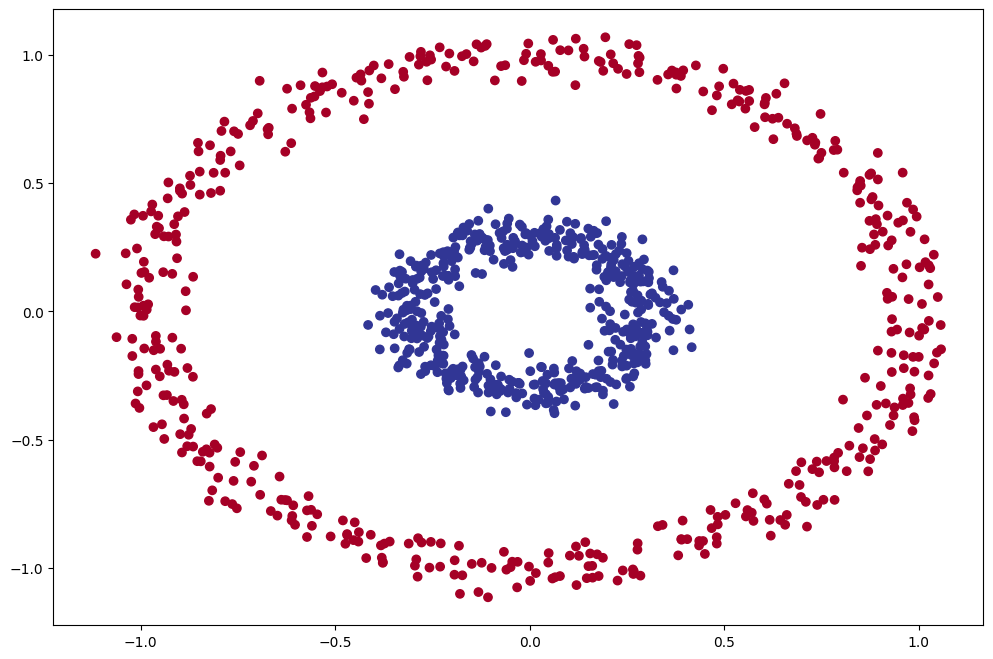

In [48]:
# plot the data
import matplotlib.pyplot as plt
plt.figure(figsize=(12, 8))
plt.scatter(x=X[:, 0], y=X[:, 1], c=y, cmap=plt.cm.RdYlBu)

### Turn Data into Tensor and Create Train and Test Splits

In [49]:
# import PyTorch
import torch

# check torch version
print(torch.__version__)

# check data type
type(X), X.dtype

2.6.0.dev20241119


(numpy.ndarray, dtype('float64'))

In [50]:
# convert data to tensor
# X_tensor = torch.from_numpy(X) # shall the type of values be converted to float32??
# y_tensor = torch.from_numpy(y) # witout conversion, the type is float64

# explicitly convert to float32
X_tensor = torch.from_numpy(X).float()
y_tensor = torch.from_numpy(y).float()

# convert data to float on purpose
X_tensor_float = X_tensor.float()
print("X_tensor_float type: ", type(X_tensor_float), X_tensor_float.dtype)

type(X_tensor), X_tensor.dtype

X_tensor_float type:  <class 'torch.Tensor'> torch.float32


(torch.Tensor, torch.float32)

> Note:
> Tensor only supports `float32` during computing prediction.
> If data is not explicitly converted to `float32` beforehand,
> it will run into the following error.

```text
---------------------------------------------------------------------------
TypeError                                 Traceback (most recent call last)
Cell In[30], line 2
      1 # Show the predictive performance of the model without training
----> 2 untrained_preds = model(X_test.to(device))
      3 # Print the untrained predictions
      4 print("Untrained model predictions:\n", untrained_preds[:10])

TypeError: Cannot convert a MPS Tensor to float64 dtype as the MPS framework doesn't support float64. Please use float32 instead.
```

In [51]:
# split data into training and test sets
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X_tensor, y_tensor, test_size=0.2, random_state=42)

len(X_train), len(X_test), len(y_train), len(y_test)

(800, 200, 800, 200)

## Building a model

TODO:
1. Setup device agnostic code, so our code will run on an accelerator (GPU) if there is one
2. Construct a model (by subclassing, `nn.Module`)
3. Define a loss function and optimizer
4. Create a training and test loop

### Device agnostic code

In [52]:
# set up device agnostic code
# Note: import pytorch if not already imported
import torch
from torch import nn

# check if macos are available
if torch.backends.mps.is_available():
    device = "mps"  # for macos
elif torch.cuda.is_available():
    device = "cuda"
else:
    device = "cpu"

print(f"Using device: {device}")

Using device: mps


### Create a model by the following steps

> forward: inputs -> layer1(input layer) -> non-linear activation -> layer2(hidden layer) -> non-linear activation -> output

1. Subclass `nn.Module` (almost all models in Pytorch subclass)
2. Create 2 `nn.Linear()` layers that are capable of handling the shapes of data (note: add a non-linear activation functions after each linear layer)
3. Defines a `forward()` method that outlines the forward pass (or forward computation) of the model
4. Instantiate an instance of our model class and send it to the target `device`

In [53]:
# Construct a model by subclassing `nn.Module`
class CircleModel(nn.Module):
    def __init__(self):
        super().__init__()
        # Define the layers of the model
        self.layer_1 = nn.Linear(in_features=2, out_features=5)
        self.layer_2 = nn.Linear(in_features=5, out_features=1)
        self.tanh = nn.Tanh()

        ## Note: there is a straitforward method to define the model by using `nn.Sequential`
        # self.model = nn.Sequential(
        #   nn.Linear(in_features=1, out_features=5),
        #   nn.Linear(in_features=5, out_features=1)
        # )

    # Define the forward pass for computing the output of the model
    def forward(self, x):
        return self.tanh(self.layer_2(self.tanh(self.layer_1(x))))

# Instantiate the model
model = CircleModel().to(device)
# Print the model architecture
print(model)
# Print the model state_dict
print(model.state_dict())

CircleModel(
  (layer_1): Linear(in_features=2, out_features=5, bias=True)
  (layer_2): Linear(in_features=5, out_features=1, bias=True)
  (tanh): Tanh()
)
OrderedDict([('layer_1.weight', tensor([[ 0.5406,  0.5869],
        [-0.1657,  0.6496],
        [-0.1549,  0.1427],
        [-0.3443,  0.4153],
        [ 0.6233, -0.5188]], device='mps:0')), ('layer_1.bias', tensor([0.6146, 0.1323, 0.5224, 0.0958, 0.3410], device='mps:0')), ('layer_2.weight', tensor([[-0.0631,  0.3448,  0.0661, -0.2088,  0.1140]], device='mps:0')), ('layer_2.bias', tensor([-0.2060], device='mps:0'))])


##### Alternative way to build model but relatively inefficient

In [54]:
# Create a model by using `nn.Sequential`
model_sequential = nn.Sequential(
    nn.Linear(in_features=2, out_features=5),
    nn.Tanh(),
    nn.Linear(in_features=5, out_features=1),
    nn.Tanh()
).to(device)
# Print the model architecture
print(model_sequential)
# Print what device the model is on
print(next(model_sequential.parameters()).device)
# Print the initial state of the model
print(model_sequential.state_dict())

Sequential(
  (0): Linear(in_features=2, out_features=5, bias=True)
  (1): Tanh()
  (2): Linear(in_features=5, out_features=1, bias=True)
  (3): Tanh()
)
mps:0
OrderedDict([('0.weight', tensor([[-0.0829, -0.2872],
        [ 0.4691, -0.5582],
        [-0.3260, -0.1997],
        [-0.4252,  0.0667],
        [-0.6984,  0.6386]], device='mps:0')), ('0.bias', tensor([-0.6007,  0.5459,  0.1177, -0.2296,  0.4370], device='mps:0')), ('2.weight', tensor([[ 0.0697,  0.3613,  0.0489, -0.1410,  0.1202]], device='mps:0')), ('2.bias', tensor([-0.1213], device='mps:0'))])


#### Loss function and optimizer as evaluation metric

In [55]:
# define loss function and optimizer
# loss_fn = nn.BCELoss()  # requires sigmoid activation
loss_fn = nn.BCEWithLogitsLoss()  # does not require sigmoid activation
optimizer = torch.optim.SGD(params=model.parameters(), lr=0.03)

# define accuracy function
def accuracy_fn(y_true, y_pred) -> float:
    """
    Calculates accuracy between y_true and y_pred
    The accuracy is the number of correct predictions
    divided by the total number of predictions.
    i.e. accuracy = (correct predictions) / (total predictions)
    """
    # compute the number of correct predictions
    correct = torch.eq(y_true, y_pred).sum().item()
    # compute the final accuracy
    acc = correct / len(y_pred)

    return acc

#### Evaluate model with data as a *Benchmark*

helper_functions.py already exists.


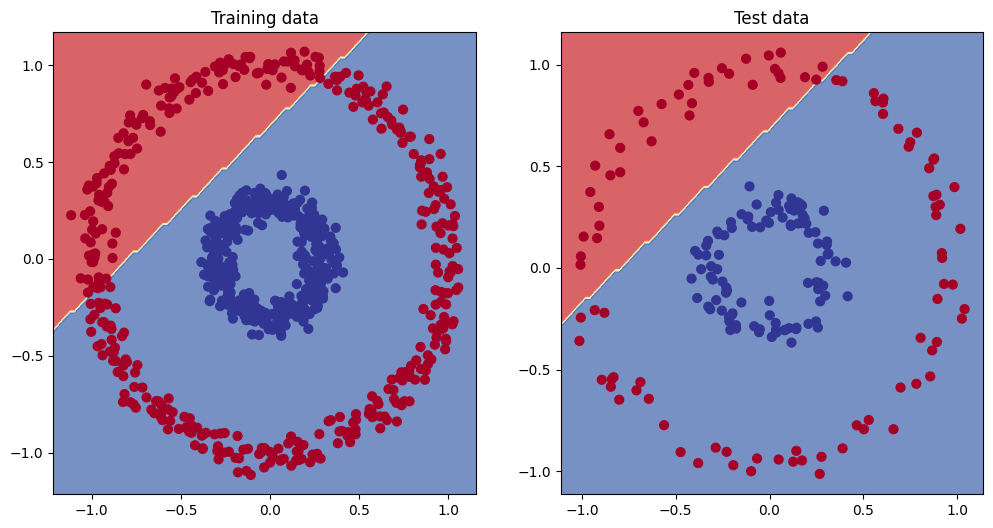

In [56]:
# import helperfunctions
import requests
from pathlib import Path

# download helper functions
if Path("helper_functions.py").is_file():
    print("helper_functions.py already exists.")
else:
    print("Downloading helper_functions.py...")
    url = "https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/helper_functions.py"
    response = requests.get(url)
    with open("helper_functions.py", "wb") as f:
        f.write(response.content)
    print("Download complete.")

# import helper functions
from helper_functions import plot_predictions, plot_decision_boundary

# Plot the decision boundary of the model
import matplotlib.pyplot as plt
# create a figure
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Training data")
plot_decision_boundary(model=model_sequential, X=X_train, y=y_train)
plt.subplot(1, 2, 2)
plt.title("Test data")
plot_decision_boundary(model=model_sequential, X=X_test, y=y_test)
plt.show()

In [57]:
# Show the predictive performance of the model without training
# turn on inference mode
with torch.inference_mode():
    untrained_preds = model(X_test.to(device))
# Print the untrained predictions
print("Untrained model predictions:\n", untrained_preds[:10])

Untrained model predictions:
 tensor([[-0.1380],
        [-0.1083],
        [-0.1610],
        [-0.1302],
        [-0.1651],
        [-0.1558],
        [-0.0631],
        [-0.0883],
        [-0.1683],
        [-0.1092]], device='mps:0')


> Note: (with and without turning on inference mode)
> Without turning on inference mode, PyTorch will keep tracking gradient which will consume extra resources.
> The following results is produced without inference mode, and it shows the `grad_fn` in the last line.

```text
Untrained model predictions:
 tensor([[-0.3138],
        [-0.2670],
        [-0.2953],
        [-0.3186],
        [-0.0960],
        [-0.0686],
        [-0.1129],
        [-0.0671],
        [-0.2999],
        [-0.2704]], device='mps:0', grad_fn=<SliceBackward0>)
```

## Training model

In [58]:
# pick a seed for reproducibility
torch.manual_seed(42)

EPOCHS = 2000

# put data to device
X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)

# Training loop
for epoch in range(EPOCHS):
    # 1. forward pass
    y_logits = model(X_train).squeeze()  # remove extra dimension
    y_pred = torch.round(torch.sigmoid(y_logits))  # apply sigmoid and round to get binary predictions
                                                   # Question: is it okay to use tanh activation here?

    # 2. calculate loss/accuracy
    loss = loss_fn(y_logits, y_train)  # calculate the loss
    acc = accuracy_fn(y_true=y_train, y_pred=y_pred)  # calculate the accuracy

    # 3. zero gradients to prevent accumulation
    optimizer.zero_grad()

    # 4. backward pass for computing gradients
    loss.backward()

    # 5. optimizer step for updating the weights
    optimizer.step()

    ### Testing for printing out what is happening
    #### turn into evaluation mode
    model.eval()
    with torch.inference_mode():
        # 1. forward pass
        test_logits = model(X_test).squeeze()  # remove extra dimension
        test_pred = torch.round(torch.sigmoid(test_logits))  # apply sigmoid and round to get binary predictions

        # 2. calculate loss/accuracy
        test_loss = loss_fn(test_logits, y_test)  # calculate the loss
        test_acc = accuracy_fn(y_true=y_test, y_pred=test_pred)  # calculate the accuracy
    
    #### print out the results
    if epoch % 100 == 0:
        print(f"Epoch: {epoch} | "
              f"Train Loss: {loss:.5f} | "
              f"Train Acc: {acc:.2f} | "
              f"Test Loss: {test_loss:.5f} | "
              f"Test Acc: {test_acc:.2f}")

Epoch: 0 | Train Loss: 0.69401 | Train Acc: 0.50 | Test Loss: 0.69586 | Test Acc: 0.50
Epoch: 100 | Train Loss: 0.68667 | Train Acc: 0.60 | Test Loss: 0.69065 | Test Acc: 0.53
Epoch: 200 | Train Loss: 0.68371 | Train Acc: 0.74 | Test Loss: 0.68901 | Test Acc: 0.71
Epoch: 300 | Train Loss: 0.68081 | Train Acc: 0.74 | Test Loss: 0.68721 | Test Acc: 0.70
Epoch: 400 | Train Loss: 0.67750 | Train Acc: 0.74 | Test Loss: 0.68497 | Test Acc: 0.70
Epoch: 500 | Train Loss: 0.67360 | Train Acc: 0.75 | Test Loss: 0.68215 | Test Acc: 0.71
Epoch: 600 | Train Loss: 0.66895 | Train Acc: 0.75 | Test Loss: 0.67861 | Test Acc: 0.72
Epoch: 700 | Train Loss: 0.66336 | Train Acc: 0.76 | Test Loss: 0.67416 | Test Acc: 0.72
Epoch: 800 | Train Loss: 0.65663 | Train Acc: 0.78 | Test Loss: 0.66860 | Test Acc: 0.73
Epoch: 900 | Train Loss: 0.64861 | Train Acc: 0.78 | Test Loss: 0.66174 | Test Acc: 0.74
Epoch: 1000 | Train Loss: 0.63916 | Train Acc: 0.79 | Test Loss: 0.65343 | Test Acc: 0.75
Epoch: 1100 | Train Lo

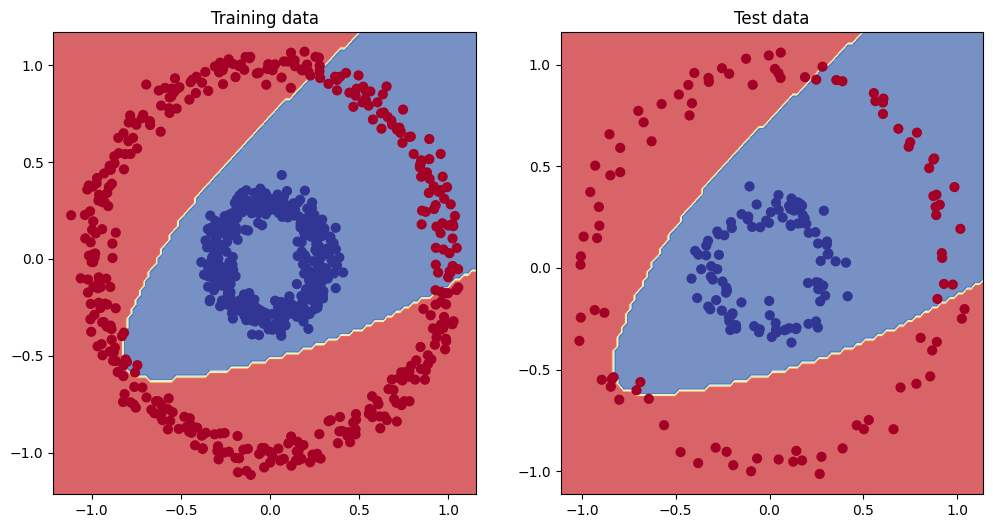

In [59]:
# plot the training results
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Training data")
plot_decision_boundary(model=model, X=X_train, y=y_train)
plt.subplot(1, 2, 2)
plt.title("Test data")
plot_decision_boundary(model=model, X=X_test, y=y_test)
plt.show()

In [6]:
### unsqueeze data
import torch

# unsqueeze the data to add a batch dimension
# create a random tensor
mock_tensor = torch.arange(0, 1, 0.1)
print("Mock tensor shape before unsqueeze: ", mock_tensor.shape)
print("Mock tensor before unsqueeze: ", mock_tensor)
# unsqueeze the tensor to add a batch dimension
mock_tensor_unsqueezed_dim0 = mock_tensor.unsqueeze(dim=0)
print("Mock tensor shape after unsqueeze (dim0): ", mock_tensor_unsqueezed_dim0.shape)
print("Mock tensor after unsqueeze (dim0): ", mock_tensor_unsqueezed_dim0)
# unsqueeze the tensor to add a batch dimension
mock_tensor_unsqueezed_dim1 = mock_tensor.unsqueeze(dim=1)
print("Mock tensor shape after unsqueeze feature (dim1): ", mock_tensor_unsqueezed_dim1.shape)
print("Mock tensor after unsqueeze feature (dim1): ", mock_tensor_unsqueezed_dim1)

Mock tensor shape before unsqueeze:  torch.Size([10])
Mock tensor before unsqueeze:  tensor([0.0000, 0.1000, 0.2000, 0.3000, 0.4000, 0.5000, 0.6000, 0.7000, 0.8000,
        0.9000])
Mock tensor shape after unsqueeze (dim0):  torch.Size([1, 10])
Mock tensor after unsqueeze (dim0):  tensor([[0.0000, 0.1000, 0.2000, 0.3000, 0.4000, 0.5000, 0.6000, 0.7000, 0.8000,
         0.9000]])
Mock tensor shape after unsqueeze feature (dim1):  torch.Size([10, 1])
Mock tensor after unsqueeze feature (dim1):  tensor([[0.0000],
        [0.1000],
        [0.2000],
        [0.3000],
        [0.4000],
        [0.5000],
        [0.6000],
        [0.7000],
        [0.8000],
        [0.9000]])
